In [31]:
%load_ext autoreload
%autoreload 2

from pandas import read_excel
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import svm, tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling

from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler 

from collections import Counter

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem,DataStructs,Draw,PandasTools,Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger

from IPython.display import Image

# Configure the logging - RDKit is rather verbose..
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
# Set the molecule representation to be SVG 
PandasTools.molRepresentation='svg'
# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()


# Loading and standardization method for SMILES -> RDKit molecule object
uncharger = rdMolStandardize.Uncharger()

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### First, let's prepare the data

In [3]:
# Loading data sets
specs = pd.read_csv('/home/jovyan/covid-data/SPECS_ready_POLINA.csv')
sss_batchA = pd.read_csv('/home/jovyan/covid-data/COVID_BatchA_ready_POLINA.csv')

In [4]:
print(f'There are {len(sss_batchA)} rows in the Batch A')

There are 5176 rows in the Batch A


Remove duplicated columns

In [5]:
# Look for duplicated columns
dup_cols = fun.getDuplicateColumns(sss_batchA)
print(f'The duplicate columns are:\n {dup_cols}')

The duplicate columns are:
 ['AreaShape_BoundingBoxMaximum_Y_cytoplasm', 'AreaShape_MinFeretDiameter_cytoplasm', 'AreaShape_BoundingBoxMinimum_X_cytoplasm', 'Intensity_MeanIntensity_illumMITO_cells.1', 'AreaShape_BoundingBoxArea_cytoplasm', 'Location_Center_Y_cytoplasm', 'Location_Center_X_nuclei', 'AreaShape_BoundingBoxMinimum_Y_cytoplasm', 'AreaShape_MaxFeretDiameter_cytoplasm', 'Location_Center_Y_nuclei', 'AreaShape_BoundingBoxMaximum_X_cytoplasm', 'Location_Center_X_cells', 'Location_Center_Y_cells', 'Location_Center_X_cytoplasm']


In [6]:
# I need to keep Intensity_MeanIntensity_illumMITO_cells.1 for later computations
iaux = dup_cols.index("Intensity_MeanIntensity_illumMITO_cells.1")
dup_cols[iaux]= 'Intensity_MeanIntensity_illumMITO_cells'

In [7]:
# Drop repeated columns
sss_batchA = sss_batchA.drop(dup_cols, axis=1)

Removing not useful columns (according to Jonne)

In [8]:
filter_col = [col for col in sss_batchA.columns if 'MITO' in col]
print(f'There are {len(filter_col)} columns containig info about MITO')
print(filter_col[-1])

There are 364 columns containig info about MITO
Intensity_MeanIntensity_illumMITO_cells.1


In [9]:
filter_col = filter_col[:-1] # IF Intensity_MeanIntensity_illumMITO_cells.1 is in the last position

In [10]:
# Drop repeated columns
sss_batchA = sss_batchA.drop(filter_col, axis=1)

In [11]:
print(f'Now the shape of Batch A is: {sss_batchA.shape}')

Now the shape of Batch A is: (5176, 1507)


In [12]:
compound_volume0 = ['CBK309099','CBK290175','CBK290175','CBK290175','CBK290175','CBK308178','CBK308178','CBK308178','CBK308178',
                    'CBK309637','CBK308501','CBK309637','CBK308501','CBK309637','CBK308501','CBK309637','CBK308501','CBK309392',
                    'CBK309392','CBK290631','CBK309251','CBK309251','CBK309251','CBK309251','CBK290950','CBK290950','CBK290950','CBK290950']

# Removing compounds from cell profiler data frame
compound_volume0_idx = [sss_batchA.index[sss_batchA['ID_covid'] == comp].to_list() for comp in compound_volume0]
compound_volume0_idx = [item for sublist in compound_volume0_idx for item in sublist]
sss_batchA = sss_batchA.drop(compound_volume0_idx)

In [13]:
print(f'Now the shape of Batch A is: {sss_batchA.shape}')

Now the shape of Batch A is: (5167, 1507)


### Now we add the information for training + cleaning

First the cell profiler

In [14]:
#Remove columns that are "human-made", hence, not useful 
cell_profiler = sss_batchA.drop(['ID_covid','PlateWellCompound','principal component 1','Ypredicted','Labels'], 1)
cell_profiler = cell_profiler.rename(columns={'Intensity_MeanIntensity_illumMITO_cells.1': 'Target'})
cell_profiler.head()

<ipython-input-14-53595da63f66>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  cell_profiler = sss_batchA.drop(['ID_covid','PlateWellCompound','principal component 1','Ypredicted','Labels'], 1)


,Count_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,Target
0,193.111111,1800.254037,2425.918124,1093.845008,1152.427871,1045.463244,1103.810619,1069.132647,1127.618663,1.138295,...,-0.041472,0.029698,-0.069107,0.015343,0.034094,0.135784,-0.012082,0.138240,0.042389,0.008777
1,242.888889,1728.176283,2305.202711,1115.833761,1161.365196,1068.625941,1113.715763,1091.731459,1137.041226,1.133682,...,-0.012074,-0.023890,0.097694,-0.024771,0.003519,0.030487,0.027094,-0.019137,-0.004051,0.008477
2,199.000000,1752.473795,2362.270982,1103.365280,1137.814079,1055.657555,1089.743856,1079.003305,1113.304014,1.139450,...,0.052860,0.019217,-0.019048,0.025002,-0.032270,-0.019920,0.020209,0.031901,0.039423,0.008487
3,226.555556,1986.790362,2626.938955,1131.691573,1115.502430,1081.084579,1064.466968,1105.880512,1089.501774,1.125735,...,-0.003855,-0.066247,-0.009865,0.105897,0.050925,-0.084664,0.028926,-0.009254,0.000593,0.005784
4,197.222222,1727.657115,2330.338123,1086.800230,1144.507585,1039.318721,1096.989619,1062.571514,1120.267519,1.137588,...,0.017231,-0.008669,-0.019241,0.012336,0.048515,0.062975,-0.019302,0.009554,0.011530,0.008265


In [15]:
cell_profiler['cell_profiler_vector'] = cell_profiler.apply(lambda r: tuple(r[0:-1]), axis=1).apply(np.array)
cell_profiler

,Count_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,Target,cell_profiler_vector
0,193.111111,1800.254037,2425.918124,1093.845008,1152.427871,1045.463244,1103.810619,1069.132647,1127.618663,1.138295,...,0.029698,-0.069107,0.015343,0.034094,0.135784,-0.012082,0.138240,0.042389,0.008777,"[193.1111111, 1800.254037, 2425.918124, 1093.8..."
1,242.888889,1728.176283,2305.202711,1115.833761,1161.365196,1068.625941,1113.715763,1091.731459,1137.041226,1.133682,...,-0.023890,0.097694,-0.024771,0.003519,0.030487,0.027094,-0.019137,-0.004051,0.008477,"[242.8888889, 1728.176283, 2305.202711, 1115.8..."
2,199.000000,1752.473795,2362.270982,1103.365280,1137.814079,1055.657555,1089.743856,1079.003305,1113.304014,1.139450,...,0.019217,-0.019048,0.025002,-0.032270,-0.019920,0.020209,0.031901,0.039423,0.008487,"[199.0, 1752.473795, 2362.270982, 1103.36528, ..."
3,226.555556,1986.790362,2626.938955,1131.691573,1115.502430,1081.084579,1064.466968,1105.880512,1089.501774,1.125735,...,-0.066247,-0.009865,0.105897,0.050925,-0.084664,0.028926,-0.009254,0.000593,0.005784,"[226.5555556, 1986.790362, 2626.938955, 1131.6..."
4,197.222222,1727.657115,2330.338123,1086.800230,1144.507585,1039.318721,1096.989619,1062.571514,1120.267519,1.137588,...,-0.008669,-0.019241,0.012336,0.048515,0.062975,-0.019302,0.009554,0.011530,0.008265,"[197.2222222, 1727.657115, 2330.338123, 1086.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5171,203.777778,1667.161061,2267.327924,1145.113236,1132.118069,1098.520189,1085.224386,1121.318458,1108.192044,1.150521,...,-0.025470,-0.138080,0.038031,-0.048695,0.029586,-0.011567,-0.031315,-0.000992,0.009815,"[203.7777778, 1667.161061, 2267.327924, 1145.1..."
5172,203.777778,1615.980907,2212.390640,1117.780128,1065.920552,1071.824189,1019.814822,1094.312557,1042.373580,1.154919,...,0.004824,-0.070471,0.042961,-0.043562,0.081066,-0.038034,-0.040628,0.102667,0.011134,"[203.7777778, 1615.980907, 2212.39064, 1117.78..."
5173,158.555556,1604.295761,2231.107003,1066.248247,1090.236381,1020.215905,1044.197701,1042.740254,1066.645620,1.169757,...,0.084618,0.067689,0.019191,-0.031676,-0.036528,0.027124,-0.138079,0.001796,0.010978,"[158.5555556, 1604.295761, 2231.107003, 1066.2..."
5174,172.555556,1598.984046,2182.850860,1092.243045,1146.370058,1046.769480,1100.123443,1068.988065,1122.763485,1.150945,...,-0.049963,0.036436,-0.011246,0.058061,-0.003082,-0.009142,0.006090,-0.046265,0.009783,"[172.5555556, 1598.984046, 2182.85086, 1092.24..."


In [75]:
cell_profiler = cell_profiler.reset_index(drop=True)
cell_profiler

,Count_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,AreaShape_Compactness_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm,Target,cell_profiler_vector
0,193.111111,1800.254037,2425.918124,1093.845008,1152.427871,1045.463244,1103.810619,1069.132647,1127.618663,1.138295,...,0.029698,-0.069107,0.015343,0.034094,0.135784,-0.012082,0.138240,0.042389,0.008777,"[193.1111111, 1800.254037, 2425.918124, 1093.8..."
1,242.888889,1728.176283,2305.202711,1115.833761,1161.365196,1068.625941,1113.715763,1091.731459,1137.041226,1.133682,...,-0.023890,0.097694,-0.024771,0.003519,0.030487,0.027094,-0.019137,-0.004051,0.008477,"[242.8888889, 1728.176283, 2305.202711, 1115.8..."
2,199.000000,1752.473795,2362.270982,1103.365280,1137.814079,1055.657555,1089.743856,1079.003305,1113.304014,1.139450,...,0.019217,-0.019048,0.025002,-0.032270,-0.019920,0.020209,0.031901,0.039423,0.008487,"[199.0, 1752.473795, 2362.270982, 1103.36528, ..."
3,226.555556,1986.790362,2626.938955,1131.691573,1115.502430,1081.084579,1064.466968,1105.880512,1089.501774,1.125735,...,-0.066247,-0.009865,0.105897,0.050925,-0.084664,0.028926,-0.009254,0.000593,0.005784,"[226.5555556, 1986.790362, 2626.938955, 1131.6..."
4,197.222222,1727.657115,2330.338123,1086.800230,1144.507585,1039.318721,1096.989619,1062.571514,1120.267519,1.137588,...,-0.008669,-0.019241,0.012336,0.048515,0.062975,-0.019302,0.009554,0.011530,0.008265,"[197.2222222, 1727.657115, 2330.338123, 1086.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162,203.777778,1667.161061,2267.327924,1145.113236,1132.118069,1098.520189,1085.224386,1121.318458,1108.192044,1.150521,...,-0.025470,-0.138080,0.038031,-0.048695,0.029586,-0.011567,-0.031315,-0.000992,0.009815,"[203.7777778, 1667.161061, 2267.327924, 1145.1..."
5163,203.777778,1615.980907,2212.390640,1117.780128,1065.920552,1071.824189,1019.814822,1094.312557,1042.373580,1.154919,...,0.004824,-0.070471,0.042961,-0.043562,0.081066,-0.038034,-0.040628,0.102667,0.011134,"[203.7777778, 1615.980907, 2212.39064, 1117.78..."
5164,158.555556,1604.295761,2231.107003,1066.248247,1090.236381,1020.215905,1044.197701,1042.740254,1066.645620,1.169757,...,0.084618,0.067689,0.019191,-0.031676,-0.036528,0.027124,-0.138079,0.001796,0.010978,"[158.5555556, 1604.295761, 2231.107003, 1066.2..."
5165,172.555556,1598.984046,2182.850860,1092.243045,1146.370058,1046.769480,1100.123443,1068.988065,1122.763485,1.150945,...,-0.049963,0.036436,-0.011246,0.058061,-0.003082,-0.009142,0.006090,-0.046265,0.009783,"[172.5555556, 1598.984046, 2182.85086, 1092.24..."


### Now training

1. Creating training and tests sets

In [79]:
# We get the input values
X =  cell_profiler.iloc[:,:-2]
# Output values
y = 1000*cell_profiler.iloc[:,-2]

In [80]:
# Re-scale
#scaler = StandardScaler()
#X = pd.DataFrame(scaler.fit_transform(X))

2) K-fold cross validationd and linear regression

In [81]:
#Parameters
thr = 7.5
cv_k = 10

In [82]:
y_frame = pd.DataFrame({'MITO': y.values.flatten()})
y_frame = fun.labelling_v2(y_frame, col_reference=0, labels_position = 1, label_positive=1, label_negative=0, threshold=thr)
y_frame = y_frame.groupby('Labels_0').count()
print(f'Percentage of positives in the total dataframe with {thr} as threshold: {y_frame.MITO[1]*100 / y_frame.MITO.sum()}%')

Percentage of positives in the total dataframe with 7.5 as threshold: 2.5933810721888912%


In [83]:
#Implementing cross validation
 
k = 5
kf = KFold(n_splits=k, random_state=None)
model = LinearRegression()
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
     
    acc = mean_squared_log_error(y_pred , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.00407109543116093, 0.00376297859972432, 0.004668584715617525, 0.0037751456431333805, 0.003163363210394607]
Avg accuracy : 0.0038882335200061528


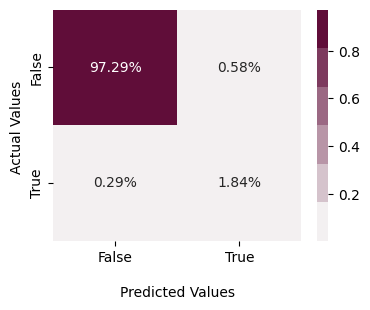

In [85]:
# Plor results
results = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': y_pred.flatten()})
results = fun.labelling_v2(results, col_reference='Actual', labels_position = 1, label_positive=1, label_negative=0, threshold=thr)
results = fun.labelling_v2(results, col_reference='Predicted', labels_position = 3, label_positive=1, label_negative=0, threshold=thr)

cd_mo = confusion_matrix(results['Labels_Actual'].tolist(), results['Labels_Predicted'].tolist())
fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax = sns.heatmap(cd_mo/np.sum(cd_mo), annot=True, fmt = '.2%', cmap=sns.light_palette((.376, .051, .224)), ax=ax)
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [ ]:
#define cross-validation method to use
cv = KFold(n_splits=cv_k, random_state=1, shuffle=True)

#build multiple linear regression model
model1 = LinearRegression()
model2 = Lasso(alpha=0.1)
model3 = svm.SVR(kernel='poly', degree = 3)
MODELS = [model1, model2, model3]

MEAN_MODEL_SCORE = []

for model in MODELS:
    
    print(f'Model: {model}')
    # Cross validation
    for train_index, test_index in cv.split()
    
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_log_error',
                             cv=cv, n_jobs=-1)
    
    
    for train_index, test_index in cv.split(X):
    X_train = iris_df.iloc[train_index].loc[:, features]
    X_test = iris_df.iloc[test_index][features]
    y_train = iris_df.iloc[train_index].loc[:,'target']
    y_test = iris_df.loc[test_index]['target']
        
    #Train the model
    model.fit(X_train, y_train) #Training the model
    
    
    y_pred = model.predict(X_test)
    #view mean absolute error
    print(f'Neg_mean_squared_log_error: {np.mean(np.abs(scores))} \n')
    MEAN_MODEL_SCORE.append(np.mean(np.abs(scores)))
          
    # Plor results
    results = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
    results = fun.labelling_v2(results, col_reference='Actual', labels_position = 1, label_positive=1, label_negative=0, threshold=thr)
    results = fun.labelling_v2(results, col_reference='Predicted', labels_position = 3, label_positive=1, label_negative=0, threshold=thr)

    cd_mo = confusion_matrix(results['Labels_Actual'].tolist(), results['Labels_Predicted'].tolist())
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax = sns.heatmap(cd_mo/np.sum(cd_mo), annot=True, fmt = '.2%', cmap=sns.light_palette((.376, .051, .224)), ax=ax)
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

In [ ]:
SCORES

In [ ]:
results